In [1]:
# Bibliotecas de uso general en el cuaderno
import json
import pickle
import os
import osmnx as ox
import geopandas as gpd
from myutils import *
from numpy import random

random.seed(0)

In [2]:
# Directorio de datos generales
path = "../GeoData/"

# Carga el grafo de la red de transporte de la Ciudad de México
g = ox.load_graphml(filepath = path + "graph_transport.graphml")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(g, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [3]:
# Carga las pltbs
pltbs = gpd.read_file(path + 'PLTBs.gpkg', layer = 'PLTBs_nodes')

# Serializa los datos de tipo lista
pltbs['streets'] = pltbs['streets'].apply(json.loads)
pltbs['oneway'] = pltbs['oneway'].apply(json.loads)
pltbs['length'] = pltbs['length'].apply(json.loads)
pltbs['capacity'] = pltbs['capacity'].apply(json.loads)
pltbs['grouped'] = pltbs['grouped'].apply(json.loads)
pltbs_grupos= [item for sublist in [ i for i in pltbs['grouped']] for item in sublist]
pltbs_nodos = list(pltbs['node'])
pltbs.set_index('node', inplace=True)
print('Grafo de transporte y PLTBs cargados')

Grafo de transporte y PLTBs cargados


In [4]:
voronoi_pltbs = nx.voronoi_cells(g, pltbs_nodos, weight='weight')
unreachable = voronoi_pltbs["unreachable"]
del(voronoi_pltbs)
g = g.remove_nodes_from(unreachable)

In [5]:
traffic_path = '../../TrafficDataAuto/'
traffic_files = [file for file in os.listdir(traffic_path) if file.endswith("_traffic_data.tar")]

In [6]:
horas = [7,8,9,11,13,15,17,19,20,21]
traffic_data = dict([(h,[]) for h in horas])

In [7]:
for f in traffic_files:
    hora = int(f.split('_')[4].split('-')[0])
    if hora in horas:
        traffic_data[hora].append(f)

7 0.96 8.15 0.99 5.43 0.99 4.08 1.0 3.26 1.0 2.72 

8 0.96 8.24 0.99 5.49 0.99 4.12 1.0 3.3 1.0 2.75 

9 0.96 8.17 0.99 5.45 1.0 4.09 1.0 3.27 1.0 2.72 

11 0.96 8.09 0.99 5.39 1.0 4.04 1.0 3.24 1.0 2.7 

13 0.96 8.38 0.99 5.59 1.0 4.19 1.0 3.35 1.0 2.79 

15 0.95 8.7 0.99 5.8 0.99 4.35 1.0 3.48 1.0 2.9 

17 0.96 8.46 0.99 5.64 0.99 4.23 1.0 3.39 1.0 2.82 

19 0.95 8.96 0.98 5.97 0.99 4.48 1.0 3.58 1.0 2.99 

20 0.95 8.7 0.99 5.8 0.99 4.35 1.0 3.48 1.0 2.9 

21 0.96 8.45 0.99 5.64 0.99 4.23 1.0 3.38 1.0 2.82 



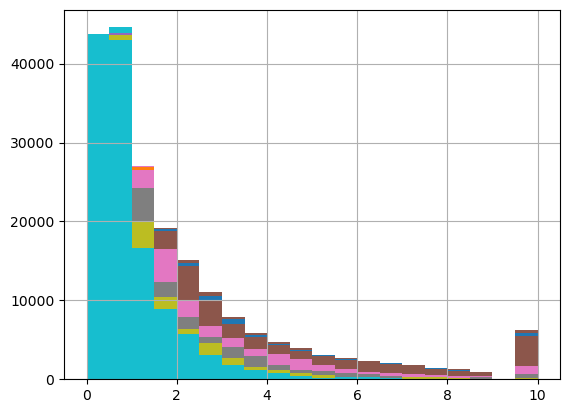

In [9]:
# Pondera las aristas según el tráfico, momentaneamente se asigna un valor de 0 a las aristas bloqueadas
weight_max = 2e20
map_vel = {1:1, 2: 2, 3: 4, 4: 6.7, 5: weight_max, 6: weight_max}
velocidades = [20,30,40,50,60]

k = []


for h in horas:

    linea = str(h) + ' '

    for vel in velocidades:
        m_x_min = vel*1000/60
        max_time = 9 #minutos

        mean_traffic = sum([pd.read_pickle(os.path.join(traffic_path, t)) for t in traffic_data[h]])/len(traffic_data[h])
        gdf_edges_h = copy(gdf_edges)
        gdf_nodes_h = copy(gdf_nodes)
        gdf_nodes_h['cell'] = 0

        gdf_edges_h = gdf_edges_h.assign(traffic = mean_traffic.round().astype(int)) 
        gdf_edges_h['weight'] = gdf_edges_h.apply(lambda x: x['length'] * map_vel[ x['traffic']], axis=1)

        g_h = ox.graph_from_gdfs(gdf_nodes, gdf_edges_h)
        voronoi_h = voronoi_cells(g_h, pltbs_nodos, weight='weight', pred=True, length=True)
        pltbs_h = pltbs.copy()

        dists = pd.Series(voronoi_h['length'],)
        dists[dists == 0] = weight_max
        dists = dists[dists < weight_max]
        dists = dists.round(4)

        dists = dists/m_x_min

        dists[ dists > max_time] = max_time + 1
        aceptable = round(sum(dists <= max_time)/len(dists),2)

        #dists.hist(bins = (max_time+1)*2)
        p95 = round(dists.quantile(q=0.95),2)

        linea += str(aceptable) + ' ' + str(p95) + ' '
    
    linea += '\n'
    print(linea)



In [ ]:
gdf_nodes_h.plot(column='cell', cmap='RdPu',
                 figsize=(5,17/2),
                 markersize=2,)